In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random

from keras.layers import Input,Flatten,Dense,Conv2D,BatchNormalization,LeakyReLU,Activation,Dropout,MaxPooling2D
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam,SGD
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
train_data = 'D:/Datasets/Covid-19/archive (4)/Data/train'
test_data = 'D:/Datasets/Covid-19/archive (4)/Data/test'

In [3]:
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size = (128,128),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 5144 images belonging to 3 classes.


In [6]:
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size = (128,128),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 1288 images belonging to 3 classes.


In [7]:
print(train_generator.class_indices)
print(test_generator.class_indices)

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [8]:
train_generator[0]

(array([[[[0.14117648, 0.14117648, 0.14117648],
          [0.14117648, 0.14117648, 0.14117648],
          [0.14117648, 0.14117648, 0.14117648],
          ...,
          [0.6648627 , 0.6648627 , 0.6648627 ],
          [0.6959593 , 0.6959593 , 0.6959593 ],
          [0.7422392 , 0.7422392 , 0.7422392 ]],
 
         [[0.14117648, 0.14117648, 0.14117648],
          [0.14117648, 0.14117648, 0.14117648],
          [0.14117648, 0.14117648, 0.14117648],
          ...,
          [0.6689363 , 0.6689363 , 0.6689363 ],
          [0.70980966, 0.70980966, 0.70980966],
          [0.74386865, 0.74386865, 0.74386865]],
 
         [[0.14117648, 0.14117648, 0.14117648],
          [0.14117648, 0.14117648, 0.14117648],
          [0.14117648, 0.14117648, 0.14117648],
          ...,
          [0.6730099 , 0.6730099 , 0.6730099 ],
          [0.7236599 , 0.7236599 , 0.7236599 ],
          [0.7454981 , 0.7454981 , 0.7454981 ]],
 
         ...,
 
         [[0.0869458 , 0.0869458 , 0.0869458 ],
          [0.06720

In [9]:
i , l = next(train_generator)

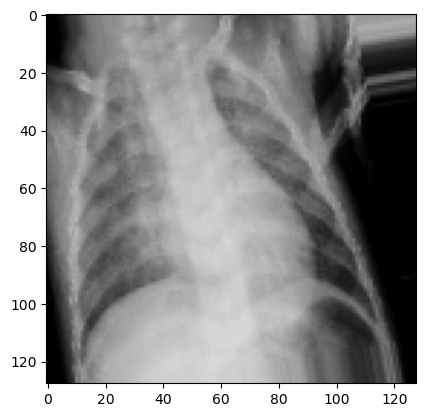

In [10]:

plt.imshow(i[10])

In [11]:
class_labels = train_generator.class_indices

In [12]:
class_labels

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [13]:
#Loading the VGG19 Model
base_model = VGG19(input_shape=(128, 128, 3),
                   include_top=False,
                   weights='imagenet')

#not to update the weight while training
for layer in base_model.layers:
    layer.trainable = False

#creates a custom model
x = base_model.output
#3D to 1D
flatten = Flatten()(x) 


layer_1 = Dense(4608, activation = 'relu')(flatten)
dropout = Dropout(0.2)(layer_1)
layer_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(3, activation = 'softmax')(layer_2)

#Creating the Model
model = Model(base_model.inputs, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,090,755 (240.67 MB)

 Trainable params: 43,066,371 (164.29 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [14]:
#callbacks and optimizers
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)

lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0., nesterov = True)

model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

C:\Users\athul\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [15]:
model.fit(train_generator,
          batch_size=32,
          epochs=10,
          shuffle=True
         )

Epoch 1/10


C:\Users\athul\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.5590 - loss: 0.9702
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - accuracy: 0.6752 - loss: 0.7911
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.6732 - loss: 0.7638
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.6915 - loss: 0.7448
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.6975 - loss: 0.7069
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.7228 - loss: 0.6683
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.7217 - loss: 0.6754
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.7241 - loss: 0.6594
Epoch 9/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.7404 - loss: 0.6391
Epoch 10/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.7426 - loss: 0.6305


In [24]:
model.evaluate(test_generator,batch_size=1000)

41/41 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8118 - loss: 0.5327


[0.5488818287849426, 0.7996894121170044]

In [17]:
CLASSES = np.array(["COVID19", "NORMAL", "PNEUMONIA"])

In [18]:
preds = model.predict(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [19]:
preds[0]

array([0.07990998, 0.6692556 , 0.25083435], dtype=float32)

In [20]:
preds_single = CLASSES[np.argmax(preds, axis= -1)]

In [21]:
preds_single[1]

'NORMAL'

In [22]:
actual_single = CLASSES[np.argmax(l, axis= -1)]

In [27]:
random_indices = random.sample(range(len(i)), 10)

In [28]:
random_indices

[26, 4, 10, 16, 6, 30, 2, 3, 14, 17]

In [32]:
random_indices = random.sample(range(len(i)), 10)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_array[idx])  # Use the correct variable here
    plt.title(f'Actual: {actual_single[idx]}\nPredicted: {preds_single[idx]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


TypeError: object of type 'int' has no len()